## **Modeling**<a class="anchor" id="modeling"></a>

In [30]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from time import time

In [9]:
# load the data
demographic = pd.read_csv('/Users/shuchitamishra/Desktop/Jobs/Study /ML-project/notebook/data/demographic.csv', index_col=False)
labs = pd.read_csv('/Users/shuchitamishra/Desktop/Jobs/Study /ML-project/notebook/data/labs.csv', index_col=False)
questionnaire = pd.read_csv('/Users/shuchitamishra/Desktop/Jobs/Study /ML-project/notebook/data/questionnaire.csv', index_col=False)

# get only gender and age columns
demographic = demographic[['SEQN', 'RIDAGEYR', 'RIAGENDR']]
# change the names of columns
demographic.rename(columns={'SEQN': 'ID', 'RIDAGEYR': 'Age', 'RIAGENDR': 'Gender'}, inplace=True)
demographic = demographic[demographic['Age'] > 9]
# categorize the data
demographic['Age'] = pd.cut(demographic['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=[1, 2, 3, 4, 5, 6], include_lowest=True)

# Get the columns of id and B12
labs = labs[['SEQN', 'LBDB12']]
# Change the names of columns
labs.rename(columns={'SEQN': 'ID', 'LBDB12': 'B12'}, inplace=True)
# Drop the records with null value in column B12
labs.dropna(axis = 0, inplace = True)
# Categorize the data
labs['B12'] = pd.cut(labs['B12'], bins=[0, 300, 950, 27000], labels=[1, 2, 3])


# Get the columns
questionnaire = questionnaire[['SEQN', 'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'DPQ100', 'SLQ050', 'SLQ060', 'IND235']]
# Change the name of id column
questionnaire.rename(columns={'SEQN': 'ID'}, inplace=True)

data = labs.merge(demographic, on="ID").merge(questionnaire, on="ID")
data.drop('ID', axis=1, inplace=True)
data.drop('DPQ100', axis=1, inplace=True)
data.dropna(subset=['DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090'], axis=0, inplace=True)
data['IND235'].replace({77: 7, 99: 7, None: 7}, inplace=True)
data[['DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'SLQ050', 'SLQ060']].replace({7: 0, 9: 0})
data['B12'] = data['B12'].astype(int)
data['Age'] = data['Age'].astype(int)
data.dropna(subset = ['IND235'], inplace = True)


### For Unbalanced Data

In [10]:
# split the data into features and target
X = data.iloc[:, 1:15]
y = data.iloc[:, 0]

# split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) # 70% training and 30% test

Benchmark classifier is a function that makes us able to compare the different algorithms.

In [11]:

# Benchmark classifier
def benchmark(clf, X_train, y_train, X_test, y_test):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [13]:
# Different algorithms
results = []
for clf, name in (
        (tree.DecisionTreeClassifier(), "Decision Tree"),
        (RandomForestClassifier(n_estimators=100), "Random Forest"),
        (GaussianNB(), "Gauissian Naive Bayes"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (LogisticRegression(), "Logistic Regression"),
        (svm.SVC(), "Support Vector Machines"),
    ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, y_train, X_test, y_test))

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.027s
test time:  0.002s
accuracy:   0.651
classification report:
              precision    recall  f1-score   support

           1       0.11      0.14      0.12       143
           2       0.80      0.80      0.80      1108
           3       0.13      0.09      0.11       160

    accuracy                           0.65      1411
   macro avg       0.34      0.34      0.34      1411
weighted avg       0.65      0.65      0.65      1411

confusion matrix:
[[ 20 106  17]
 [143 883  82]
 [ 27 118  15]]
Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.211s
test time:  0.023s
accuracy:   0.759
classification report:
              precision    recall  f1-score   support

           1       0.09      0.02      0.03       143
           2       0.79   

/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

train time: 0.663s
test time:  0.282s
accuracy:   0.785
classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       143
           2       0.79      1.00      0.88      1108
           3       0.00      0.00      0.00       160

    accuracy                           0.79      1411
   macro avg       0.26      0.33      0.29      1411
weighted avg       0.62      0.79      0.69      1411

confusion matrix:
[[   0  143    0]
 [   0 1108    0]
 [   0  160    0]]


/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

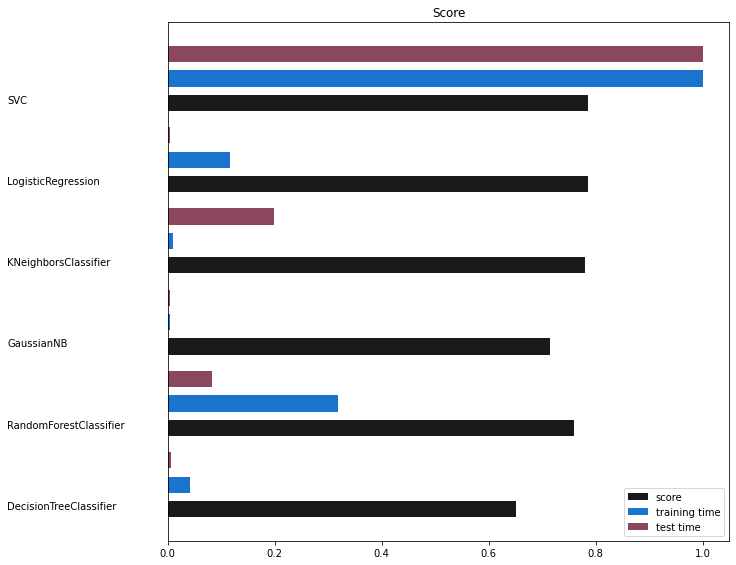

In [15]:
# plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='#1A1A1A')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='#1874CD')
plt.barh(indices + .6, test_time, .2, label="test time", color='#8B475D')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

When comparing the accuracy of the models, two algorithms with the highest accuracy are Logistic Regression and Support Vector Classifier, but when we consider 'precision', 'recall' and 'f1score' values, it is not very successful models, only 'Normal' value B12 prediction we can see what model did. Therefore, when we compare these two models, we will use the Gaussian Naive Bayes algorithm in our project, whose accuracy rate is not very different, but also predicts other categories.

Since 'hyperparameters' cannot be made in the Gaussian Naive Bayes algorithm, we cannot use Grid Search. Instead, we try the Grid Search algorithm to see if we can get better results in Random Forest, the best model after Naive Bayes.

In [16]:
forest = RandomForestClassifier(random_state=1, n_estimators = 10, min_samples_split = 1)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [17]:
# best parameters on model
gridF.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [18]:
gridF.refit
preds = gridF.predict(X_test)
probs = gridF.predict_proba(X_test)

# accuracy score
np.mean(preds == y_test)

0.7852586817859674

In [19]:
print(metrics.classification_report(y_test, preds, target_names=['Low', 'Normal', 'High']))

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       143
      Normal       0.79      1.00      0.88      1108
        High       0.00      0.00      0.00       160

    accuracy                           0.79      1411
   macro avg       0.26      0.33      0.29      1411
weighted avg       0.62      0.79      0.69      1411



/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

As a result of Grid Search, we see that the accuracy rate increased by 3%, but caused a negative effect on the classification report. We see that it cannot predict low and high B12 categories (1 and 3). Therefore, we continue with the Naive Bayes algorithm.

### With Balanced Data

We have seen above that there are many more participants with "Normal" B12 in our data. Therefore, we will make the categories more balanced and reconstruct our model. There are about 530 data in other categories. We select 1000 data from the normal category. The reason for this is that we do not want to lose too much data.

In [20]:
balanced_data = data.copy()

balanced_data[balanced_data['B12'] == 2] = balanced_data[balanced_data['B12'] == 2].sample(1000, random_state=42)
balanced_data = balanced_data[balanced_data['B12'].notnull()]
balanced_data['B12'].value_counts()

2.0    1000
3.0     517
1.0     515
Name: B12, dtype: int64

In [21]:
# split the data into features and target
X_balanced = balanced_data.iloc[:, 1:15]
y_balanced = balanced_data.iloc[:, 0]

# split the data into test and train
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, shuffle=True) # 70% training and 30% test

In [22]:
results_balanced = []
for clf, name in (
        (tree.DecisionTreeClassifier(), "Decision Tree"),
        (RandomForestClassifier(n_estimators=100), "Random Forest"),
        (GaussianNB(), "Gauissian Naive Bayes"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (LogisticRegression(), "Logistic Regression"),
        (svm.SVC(), "Support Vector Machines"),
    ):
    print('=' * 80)
    print(name)
    results_balanced.append(benchmark(clf, X_train_balanced, y_train_balanced, X_test_balanced, y_test_balanced))

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier()
train time: 0.028s
test time:  0.002s
accuracy:   0.375
classification report:
              precision    recall  f1-score   support

         1.0       0.23      0.27      0.25       154
         2.0       0.52      0.53      0.52       300
         3.0       0.23      0.19      0.21       156

    accuracy                           0.38       610
   macro avg       0.33      0.33      0.33       610
weighted avg       0.37      0.38      0.37       610

confusion matrix:
[[ 42  75  37]
 [ 82 158  60]
 [ 55  72  29]]
Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.173s
test time:  0.015s
accuracy:   0.403
classification report:
              precision    recall  f1-score   support

         1.0       0.25      0.18      0.21       154
         2.0       0.49   

/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train time: 0.169s
test time:  0.089s
accuracy:   0.492
classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       154
         2.0       0.49      1.00      0.66       300
         3.0       0.00      0.00      0.00       156

    accuracy                           0.49       610
   macro avg       0.16      0.33      0.22       610
weighted avg       0.24      0.49      0.32       610

confusion matrix:
[[  0 153   1]
 [  0 300   0]
 [  0 156   0]]


/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

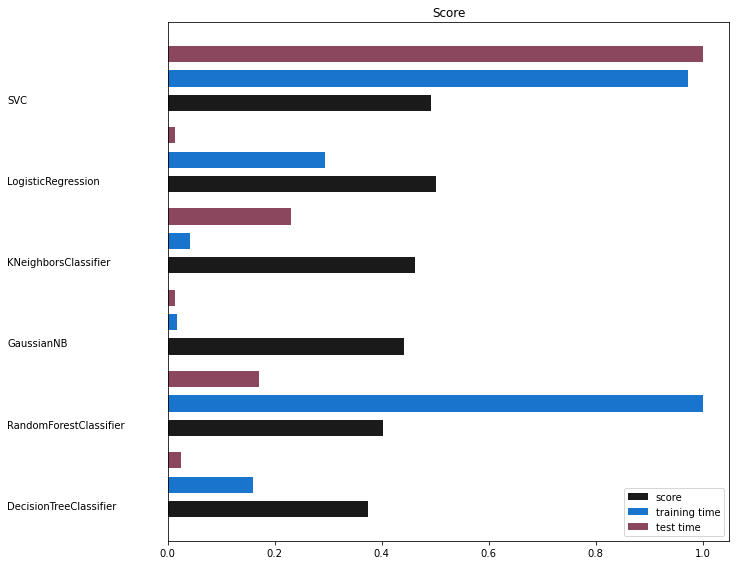

In [23]:
# make plots

indices = np.arange(len(results_balanced))

results_balanced = [[x[i] for x in results_balanced] for i in range(4)]

clf_names, score, training_time, test_time = results_balanced
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='#1A1A1A')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='#1874CD')
plt.barh(indices + .6, test_time, .2, label="test time", color='#8B475D')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

Accuracy rate is lower than unbalanced data. Again, considering the accuracy rate, f1score, recall and precision values, we can see that the Gaussian Naive Bayes algorithm works better.

In [24]:
gridF_balanced = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF_balanced = gridF_balanced.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [25]:
gridF_balanced.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 100}

In [26]:
gridF_balanced.refit
preds = gridF_balanced.predict(X_test_balanced)
probs = gridF_balanced.predict_proba(X_test_balanced)

# accuracy score
np.mean(preds == y_test_balanced)

0.49508196721311476

In [27]:
print(metrics.classification_report(y_test_balanced, preds, target_names=['Low', 'Normal', 'High']))

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       154
      Normal       0.50      0.97      0.66       300
        High       0.42      0.06      0.11       156

    accuracy                           0.50       610
   macro avg       0.31      0.35      0.26       610
weighted avg       0.35      0.50      0.35       610



As with the unbalanced data set, our accuracy rate increased by about 6% but had a negative impact on our classification report.

## **Evaluation**<a class="anchor" id="evaluation"></a>

In [28]:
model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Accuracy score is {}".format(metrics.accuracy_score(y_test, pred)))
print(metrics.classification_report(y_test, pred, target_names=['Low', 'Normal', 'High']))

Accuracy score is 0.7143869596031184
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       143
      Normal       0.79      0.90      0.84      1108
        High       0.10      0.09      0.10       160

    accuracy                           0.71      1411
   macro avg       0.30      0.33      0.31      1411
weighted avg       0.63      0.71      0.67      1411



/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuchitamishra/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Recall is ability of a classification model to identify all relevant instances.
We can see that recall is only good for normal B12 values. Model is not very successful for low and high.

Precision is ability of a classification model to return only relevant instances.
Our model is so successful at normal values but not very successful at low and high values.


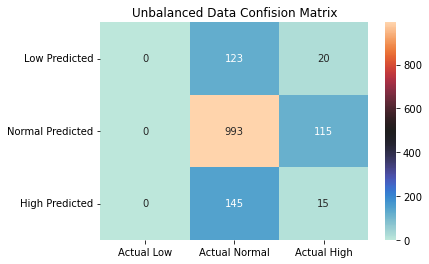

In [31]:
rslt = metrics.confusion_matrix(y_test, pred)
sns.heatmap(pd.DataFrame(rslt, index=['Low Predicted', 'Normal Predicted', 'High Predicted'], columns=['Actual Low', 'Actual Normal', 'Actual High']), annot=True, fmt='d', cmap='icefire')
plt.title('Unbalanced Data Confision Matrix')
plt.show()

Confision matrix shows that, model tends to predict normal values more. The reason is data is unbalanced and normal values are much more than others. We can see that, model predicts 80 values as normal but actually low or high.


In [32]:
model.fit(X_train_balanced, y_train_balanced)
pred_balanced = model.predict(X_test_balanced)

print("Accuracy score for balanced data is {}".format(metrics.accuracy_score(y_test_balanced, pred_balanced)))
print(metrics.classification_report(y_test_balanced, pred_balanced, target_names=['Low', 'Normal', 'High']))

Accuracy score for balanced data is 0.44098360655737706
              precision    recall  f1-score   support

         Low       0.17      0.06      0.09       154
      Normal       0.50      0.77      0.61       300
        High       0.30      0.18      0.22       156

    accuracy                           0.44       610
   macro avg       0.32      0.34      0.31       610
weighted avg       0.37      0.44      0.38       610



Recall is ability of a classification model to identify all relevant instances.
Recall of balanced data looks better than recall of unbalanced data. High values are now having a good percentage of recall, normal is still good. Low could be better.

Precision is ability of a classification model to return only relevant instances.
Precision of balanced data is much better than precision of unbalanced data. All categories have now acceptable precisions.


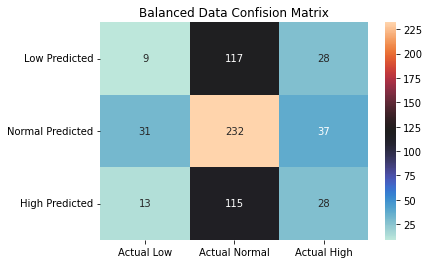

In [33]:
rslt_balanced = metrics.confusion_matrix(y_test_balanced, pred_balanced)
sns.heatmap(pd.DataFrame(rslt_balanced, index=['Low Predicted', 'Normal Predicted', 'High Predicted'], columns=['Actual Low', 'Actual Normal', 'Actual High']), annot=True, fmt='d', cmap='icefire')
plt.title('Balanced Data Confision Matrix')
plt.show()

Now the result with balanced data shows that model not tend to predict normal values more. It predicts all values but because of accuracy is bad, it predicts more wrongly.

---


When we compare the two results, we can see that the accuracy rate is better for the unbalanced data set, but when we look at the classification report, we can see that the balanced data set is better.

## **References**<a class="anchor" id="references"></a>



*   https://github.com/Jean-njoroge/Breast-cancer-risk-prediction
*   https://dizziness-and-balance.com/disorders/central/b12.html
